# Selection of krypton events in terms of S1 and S2

## Authors: JMH, JAH, GML, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- <RUN_PARAMS>


In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Oct 21 13:07:47 2019


In [2]:
run_number  = 7517
file_range  = 0, 1 
num_files = 1
analysis_tag = 'ScriptTest'
output = False

if num_files > 7729:
    num_xy_bins = 100
else:
    num_xy_bins = 50

num_xy_bins = 10
    
t0 = time.time()
last_time = t0

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/"+analysis_tag+"/dst"
trigger     = 'trigger1'

bootstrap_correction_filename   = '/Users/jmhaefner/Development/KryptonCalibration/InteractiveNBs/ICAROS_NBS/kr_emap_xy_100_100_r_6573_time.h5'
write_filtered_dst = True

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [6]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [7]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [8]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [9]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [10]:
from krcal.core.core_functions          import time_delta_from_time

### Create vals file

### Input/output 

In [11]:
input_dst_filenames = ['/Users/jmhaefner/Development/KryptonCalibration/InteractiveNBs/ICAROS_NBS/kdst_7517_LB_0-100_TestMapScript.h5']
output_dst_filename = 'dst_test.h5'
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")

print('time before dst load =', round(time.time() - last_time))
last_time = time.time()

input dsts:
 first = /Users/jmhaefner/Development/KryptonCalibration/InteractiveNBs/ICAROS_NBS/kdst_7517_LB_0-100_TestMapScript.h5
 last = /Users/jmhaefner/Development/KryptonCalibration/InteractiveNBs/ICAROS_NBS/kdst_7517_LB_0-100_TestMapScript.h5
output dst = dst_test.h5
time before dst load = 7


In [12]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")
print('time to load dst =', round(time.time() - last_time))
last_time = time.time()

time to load dst = 1


In [13]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 63176 
Total number of events: 54091


### Select events with 1 S1

In [14]:
dst1s1 = dst_full[dst_full.nS1==1]

### Select events with 1 S2

In [15]:
dst    = dst1s1[dst1s1.nS2==1]

### Cut on R < 200

In [16]:
dst     = dst[dst.R < 200]

### Fiducial selection in S1

#### 3 < S1e < 25 pes, which cuts off very low and high energy events

In [17]:
s1e_range =(3, 25)

In [18]:
dst    = dst[in_range(dst.S1e, *s1e_range)] 

### Fiducial selection in S2

In [19]:
s2e_range =(8000, 14000)
s2q_range =(200, 800)

In [20]:
dst_s2e    = dst[in_range(dst.S2e, *s2e_range)]
dst_s2q    = dst_s2e[in_range(dst_s2e.S2q, *s2q_range)]
dst = dst_s2q

### Time differences in seconds

In [21]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Define ranges and bins

In [22]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = (-200,  200),
                                                        yrange    = (-200,  200),
                                                        zrange    = (10,  550),
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 25,
                                                        s2qnbins  = 25,
                                                        tpsamples = 1) # tsamples in seconds

In [23]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

### Select central region in R 

#### The effect is to reduce the dependence of geometrical corrections

In [24]:
dst_R     = dst[dst.R < 100]

### Select central region in Z

- The effect is to reduce the dependence of lifetime

In [25]:
dst_core     = dst_R[dst_R.Z < 200]

### Apply bootstrap corrections.

- One can correct S2e and S2q by geometrical corrections using an existing map (a bootstrap map). This has the effect to reduce the geometrical dependence on both distributions, permitting an additional filtering

In [26]:
kre = kr_event(dst)

In [27]:
from krcal.core.io_functions       import read_maps
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.map_functions   import amap_max

emaps = read_maps(filename=bootstrap_correction_filename)
norm = amap_max(emaps)
E = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = 100, 
                      ny  = 100)
Q = e0_xy_correction(dst.S2q.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = 100, 
                      ny  = 100)

In [28]:
kge = kr_event(dst, DT, E, Q)

### Filter

In [29]:
range_krs2 = (10e+3,14e+3)

In [30]:
sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z, E,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 15,
                                                 nbins_e = 25,
                                                 nsigma  = 3.5)


/Users/jmhaefner/ICAROS/krcal/core/fit_functions.py:48: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/ICAROS/krcal/core/fit_functions.py:48: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


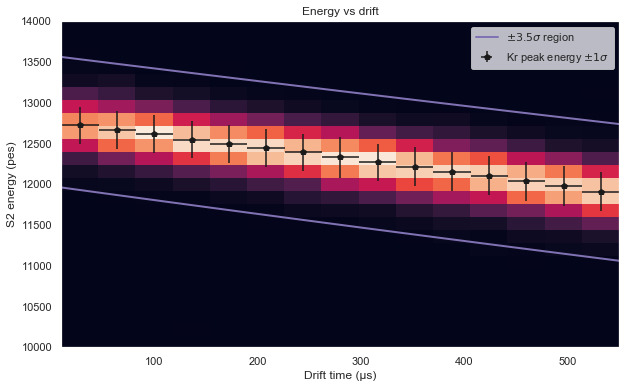

In [31]:
plot_selection_in_band(fpl, fph, hp, pp)

In [32]:
kges = kr_event(dst, DT, E, Q, sel_mask=sel_krband)

### Select dst 

In [33]:
dsts = dst[sel_krband]

### Write DST (merged and fiducial)

In [34]:
print('Time after loading to before writing =', round(time.time() - last_time))
last_time = time.time()

Time after loading to before writing = 4


In [35]:
if output:
    import subprocess

    bash_mkdir = "mkdir " + os.environ['IC_DATA']+analysis_tag
    process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()
    bash_mkdir = "mkdir " + output_dst_filename[:output_dst_filename.rfind('/')+1]
    process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

    output_dst = tb.open_file(output_dst_filename, 'w')

    from invisible_cities.io.dst_io import _store_pandas_as_tables
    import h5py

    _store_pandas_as_tables(h5out = output_dst, df = dsts, group_name = 'DST', table_name = 'Events')

    output_dst.close()

# Krypton Lifetime maps

### Author:  JMH, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [36]:
from krcal.core.kr_types import KrFileName

input_tag = 'ScriptTest'

regularize = False

t_start = time.time()

lifetime_limits = (1000, 15000)
e0_limits = (7000, 14000)
e0_limits_rphi = (12000, 14000)

input_path  = f"$IC_DATA/"+input_tag+"/dst"
map_path    = f"$IC_DATA/"+analysis_tag+"/maps"

input_file_name = 'dst_test.h5'
input_file_names  = [ input_file_name ]
    
time_bins = 10
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_'+str(run_number)+'.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_'+str(run_number)+'.h5'
emap_file_name    = 'kr_emap_xy_'+str(num_xy_bins)+'_'+str(num_xy_bins)+'_r_'+str(run_number)+'_'+analysis_tag+'.h5'

In [37]:
import warnings
from krcal.core.io_functions       import write_maps
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import add_mapinfo
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

### Input/output 

In [38]:
t0 = time.time()
dst = dsts
if output:
    dst           = load_dsts([input_file_name], "DST", "Events")
t1 = time.time()
print(f'Read in file time: t = {t1 -t0}')

Read in file time: t = 8.20159912109375e-05


In [39]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 40551


### Time differences in seconds

In [40]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [41]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (10000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 18000)
lt_range = (1000, 9000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 25,
                                                        s2qnbins  = 25,
                                                        tpsamples = 1) # tsamples in seconds

In [42]:
dstFid = dst[in_range(dst.R, 0, RMAX)]

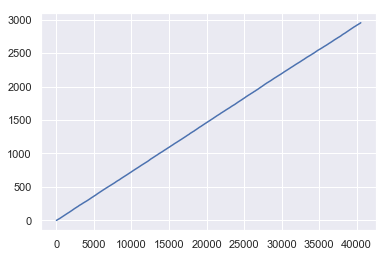

In [43]:
dst_time = dstFid.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst_time.assign(DT=DT)
plt.plot(DT)
plt.show()

In [44]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

## Divide chamber in sectors of XY

In [45]:
t0 = time.time()
KRES = select_xy_sectors_df(dst, krBins.X, krBins.Y)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 0.23964905738830566


In [46]:
neM = event_map_df(KRES)

## Fits in XY sectors

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [47]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy_df(selection_map = KRES,
                       event_map     = neM,
                       n_time_bins   = 1,
                       time_diffs    = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 2)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 0.6081359386444092


In [48]:
times = fpmxy[0][0].ts

In [49]:
tsm = tsmap_from_fmap(fpmxy)

#### There is a single time series (ts = 0)

In [50]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

#### Get rid of outlayers that distort mean and error

In [51]:
def asm_copy(amap):
    return ASectorMap(chi2  = amap.chi2.copy(),
                      e0    = amap.e0.copy(),
                      lt    = amap.lt.copy(),
                      e0u   = amap.e0u.copy(),
                      ltu   = amap.ltu.copy(),
                      mapinfo   = None)

def regularize_maps_chi2(amap_old, x2range):

    amap = asm_copy(amap_old)
    
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if amap.chi2[i][j] > x2range[1] or amap.chi2[i][j] < x2range[0]:
                amap.lt[i][j] = np.nan
                amap.ltu[i][j] = np.nan
                amap.e0[i][j] = np.nan
                amap.e0u[i][j] = np.nan

    return amap

In [52]:
if regularize:
    rmap = regularize_maps_chi2(am, x2range = (0, 2))
    amap_average(rmap)
    asm = relative_errors(rmap)
else:
    asm = relative_errors(am)

In [53]:
amv = amap_average(asm)

#### Draw the maps using default colormap

In [54]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

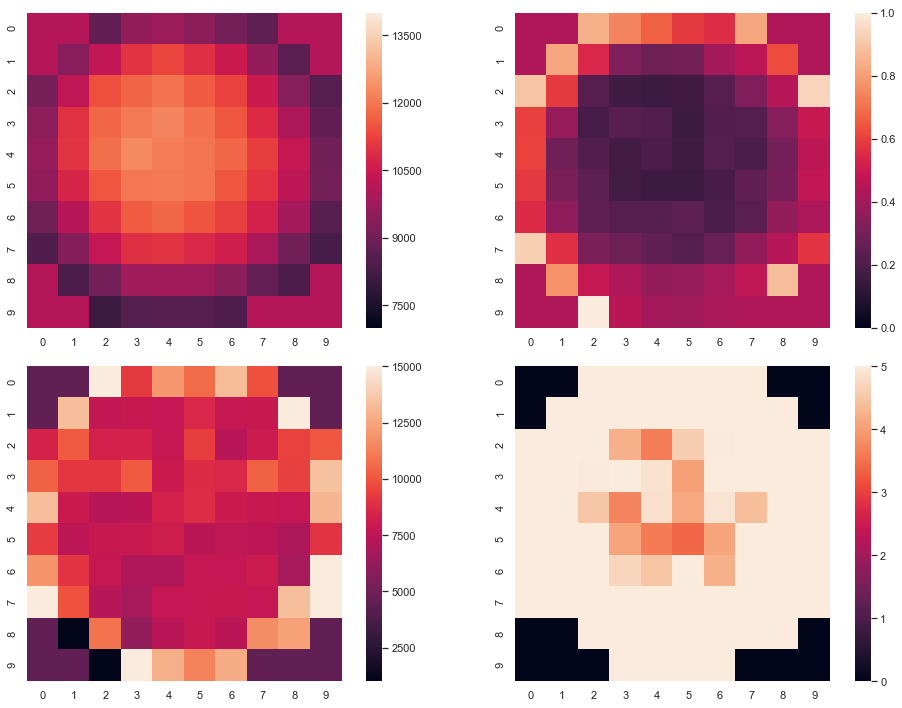

In [55]:
draw_xy_maps(asmAv,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [56]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [57]:
emap_file_name

'kr_emap_xy_10_10_r_7517_ScriptTest.h5'

In [58]:
print('The map info is:')
print(asm.mapinfo)
if output:
    write_maps(asm, filename=emap_file_name)

The map info is:
xmin          -200
xmax           200
ymin          -200
ymax           200
nx              10
ny              10
run_number    7517
dtype: int64
